In [1]:
import os
import sys
import math
import pickle as pkl
import shutil
import argparse
from pathlib import Path
import torch.nn as nn
import torch

import cv2
import numpy as np
import torch
import scipy.io as sio
import scipy.special
import matplotlib.pyplot as plt
from pathlib import Path
from beartype import beartype
from zsvision.zs_utils import BlockTimer
from tqdm import tqdm
from demo import models
from demo.utils_demo import torch_to_list, to_torch, im_to_numpy, im_to_torch, resize_generic, color_normalize, save_pred, generate_vtt_file
from demo.viz_demo import video_results


### Remark:
Pretrained models should be imported in corresponding folders for the model to run:
-"model" folder in working directory: with i3d pretrained model in folder called "i3d" and "asformer" trained model in folder "asformer" under name "asformer_bslcp.model"

In [3]:
def load_rgb_video(video_path: Path, fps: int) -> torch.Tensor:
    """
    Load frames of a video using cv2.
    """
    cap = cv2.VideoCapture(str(video_path))
    cap_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    cap_fps = cap.get(cv2.CAP_PROP_FPS)

    # cv2 won't be able to change frame rates for all encodings, so we use ffmpeg
    if cap_fps != fps:
        tmp_video_path = f"{video_path}.tmp.{Path(video_path).suffix}"
        shutil.move(video_path, tmp_video_path)
        cmd = (f"ffmpeg -i {tmp_video_path} -pix_fmt yuv420p "
               f"-filter:v fps=fps={fps} {video_path}")
        print(f"Generating new copy of video with frame rate {fps}")
        os.system(cmd)
        Path(tmp_video_path).unlink()
        cap = cv2.VideoCapture(str(video_path))
        cap_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        cap_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        cap_fps = cap.get(cv2.CAP_PROP_FPS)
        print(cap_fps)
        assert cap_fps == fps, f"ffmpeg failed to produce a video at {fps}"

    f = 0
    rgb = []
    while True:
        # frame: BGR, (h, w, 3), dtype=uint8 0..255
        ret, frame = cap.read()
        if not ret:
            break
        # BGR (OpenCV) to RGB (Torch)
        frame = frame[:, :, [2, 1, 0]]
        rgb_t = im_to_torch(frame)
        rgb.append(rgb_t)
        f += 1
    cap.release()
    # (nframes, 3, cap_height, cap_width) => (3, nframes, cap_height, cap_width)
    rgb = torch.stack(rgb).permute(1, 0, 2, 3)
    print(f"Loaded video {video_path} with {f} frames [{cap_height}hx{cap_width}w] res. "
          f"at {cap_fps}")
    return rgb


def prepare_input(
    rgb: torch.Tensor,
    resize_res: int = 256,
    inp_res: int = 224,
    mean: torch.Tensor = 0.5 * torch.ones(3), std=1.0 * torch.ones(3),
):
    """
    Process the video:
    1) Resize to [resize_res x resize_res]
    2) Center crop with [inp_res x inp_res]
    3) Color normalize using mean/std
    """
    iC, iF, iH, iW = rgb.shape
    rgb_resized = np.zeros((iF, resize_res, resize_res, iC))
    for t in range(iF):
        tmp = rgb[:, t, :, :]
        tmp = resize_generic(
            im_to_numpy(tmp), resize_res, resize_res, interp="bilinear", is_flow=False
        )
        rgb_resized[t] = tmp
    rgb = np.transpose(rgb_resized, (3, 0, 1, 2))
    # Center crop coords
    ulx = int((resize_res - inp_res) / 2)
    uly = int((resize_res - inp_res) / 2)
    # Crop 256x256
    rgb = rgb[:, :, uly : uly + inp_res, ulx : ulx + inp_res]
    rgb = to_torch(rgb).float()
    assert rgb.max() <= 1
    rgb = color_normalize(rgb, mean, std)
    return rgb

def load_i3d_model(
        i3d_checkpoint_path: Path,
        num_classes: int,
        num_in_frames: int,
) -> torch.nn.Module:
    """Load pre-trained I3D checkpoint, put in eval mode."""
    model = models.InceptionI3d(
        num_classes=num_classes,
        spatiotemporal_squeeze=True,
        final_endpoint="Logits",
        name="inception_i3d",
        in_channels=3,
        dropout_keep_prob=0.5,
        num_in_frames=num_in_frames,
        include_embds=True,
    )
    #model = torch.nn.DataParallel(model).cuda()
    model = torch.nn.DataParallel(model)
    #checkpoint = torch.load(i3d_checkpoint_path)
    checkpoint = torch.load(i3d_checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint["state_dict"])
    model.eval()
    return model

def load_asformer_model(
        asformer_checkpoint_path: Path,
        device,
        num_encoders: int = 3,
        num_layers: int = 9,
        r1: int = 2,
        r2: int = 2, 
        num_f_maps: int = 64, 
        input_dim: int = 1024, 
        num_classes: int = 2, 
        channel_masking_rate=0.3,

) -> torch.nn.Module:
    """Load pre-trained ASFormer checkpoint, put in eval mode."""
    #model = models.MultiStageModel(
    #)
    model = models.asformer.MyTransformer(
        num_encoders,
        num_layers,
        r1, r2, 
        num_f_maps, 
        input_dim, 
        num_classes, 
        channel_masking_rate)

    model = model.to(device)
    #checkpoint = torch.load(asformer_checkpoint_path)
    checkpoint = torch.load(asformer_checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint)
    model.eval()
    return model

def sliding_windows(
        rgb: torch.Tensor,
        num_in_frames: int,
        stride: int,
) -> tuple:
    """
    Return sliding windows and corresponding (middle) timestamp
    """
    C, nFrames, H, W = rgb.shape
    # If needed, pad to the minimum clip length
    if nFrames < num_in_frames:
        rgb_ = torch.zeros(C, num_in_frames, H, W)
        rgb_[:, :nFrames] = rgb
        rgb_[:, nFrames:] = rgb[:, -1].unsqueeze(1)
        rgb = rgb_
        nFrames = rgb.shape[1]

    num_clips = math.ceil((nFrames - num_in_frames) / stride) + 1
    plural = ""
    if num_clips > 1:
        plural = "s"
    print(f"{num_clips} clip{plural} resulted from sliding window processing.")

    rgb_slided = torch.zeros(num_clips, 3, num_in_frames, H, W)
    t_mid = []
    # For each clip
    for j in range(num_clips):
        # Check if num_clips becomes 0
        actual_clip_length = min(num_in_frames, nFrames - j * stride)
        if actual_clip_length == num_in_frames:
            t_beg = j * stride
        else:
            t_beg = nFrames - num_in_frames
        t_mid.append(t_beg + num_in_frames / 2)
        rgb_slided[j] = rgb[:, t_beg : t_beg + num_in_frames, :, :]
    return rgb_slided, np.array(t_mid)


def main_i3d(
    starting_point: str,
    i3d_checkpoint_path: Path,
    asformer_checkpoint_path: Path,
    video_path: Path,
    feature_path: Path,
    save_path: Path,
    fps: int,
    num_classes: int,
    num_in_frames: int,
    batch_size: int,
    stride: int,
    slowdown_factor: int,
    save_features: bool,
    save_segments: bool,
    viz: bool,
    generate_vtt: bool,
):
    with BlockTimer("Loading I3D model"):
        model = load_i3d_model(
            i3d_checkpoint_path=i3d_checkpoint_path,
            num_classes=num_classes,
            num_in_frames=num_in_frames,
        )
    with BlockTimer("Loading video frames"):
        rgb_orig = load_rgb_video(
            video_path=video_path,
            fps=fps,
        )
    # Prepare: resize/crop/normalize
    rgb_input = prepare_input(rgb_orig)
    # Sliding window
    rgb_slides, t_mid = sliding_windows(
        rgb=rgb_input,
        stride=stride,
        num_in_frames=num_in_frames,
    )
    # Number of windows/clips
    num_clips = rgb_slides.shape[0]
    # Group the clips into batches
    num_batches = math.ceil(num_clips / batch_size)
    all_features = torch.Tensor(num_clips, 1024)
    all_logits = torch.Tensor(num_clips, num_classes)
    for b in range(num_batches):
        inp = rgb_slides[b * batch_size : (b + 1) * batch_size]
        # Forward pass
        out = model(inp)
        logits = out["logits"].data.cpu()
        all_features[b] = out["embds"].squeeze().data.cpu()
        all_logits[b] = logits.squeeze().data.cpu()

    if save_features:
        save_pred(
            all_features, checkpoint=save_path, filename="features.mat",
        )
    
    return all_features, all_logits

def main_asformer(
    features,
    logits,
    starting_point: str,
    i3d_checkpoint_path: Path,
    asformer_checkpoint_path: Path,
    video_path: Path,
    feature_path: Path,
    save_path: Path,
    fps: int,
    num_classes: int,
    num_in_frames: int,
    batch_size: int,
    stride: int,
    slowdown_factor: int,
    save_features: bool,
    save_segments: bool,
    viz: bool,
    generate_vtt: bool,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with BlockTimer("Loading ASFormer model"):
        model = load_asformer_model(
            asformer_checkpoint_path=asformer_checkpoint_path,
            device=device
        )

    print("Predict segments.")
    sm = nn.Softmax(dim=1)

    # Number of windows/clips
    num_clips = features.shape[0]//100
    # Group the clips into batches
    num_batches = math.ceil(num_clips)

    all_preds = []
    all_probs = []

    for b in range(num_batches+1):
        inp = features[b * 100 : (b + 1) * 100]
        inp = np.swapaxes(inp, 0, 1)
        inp = inp.unsqueeze(0).to(device)
    
        predictions = model(inp, torch.ones(inp.size(), device=device))
        pred_prob = list(sm(predictions[-1]).cpu().detach().numpy())[0][1]
        predicted = torch.tensor(np.where(np.asarray(pred_prob) > 0.5, 1, 0))

        all_preds.extend(torch_to_list(predicted))
        all_probs.extend(pred_prob)
    if save_segments:
        print("Save results.")
        pkl.dump(all_preds, open(save_path + '/predictions.pkl', "wb")) 
        pkl.dump(all_probs, open(save_path + '/probabilities.pkl', "wb"))

    if generate_vtt:
        print("Generate .vtt file")
        generate_vtt_file(all_preds, logits, save_path)

    if viz:
        if starting_point=="feature":
            print("Please choose 'video' as starting point to generate a visualization.")
        else:
            print("Create visualization.")
            Path(save_path).mkdir(exist_ok=True, parents=True)
            video_results(
                video_path,
                all_preds,
                all_probs,
                save_path,
                slowdown_factor,
            )

In [4]:
class Demo_args():
    def __init__(self, *args, **kwargs):
      self.starting_point="video"
      self.i3d_checkpoint_path = "model/i3d/i3d_kinetics_bslcp.pth.tar"
      self.asformer_checkpoint_path="model/asformer/asformer_bslcp.model"
      self.video_path="demo/sample_data/demo_video.mp4"
      self.feature_path="data/features/bslcp/i3d_kinetics_bslcp_981/train/features.mat"
      self.save_path="demo/results"
      self.num_in_frames=16
      self.stride=1
      self.batch_size=1
      self.fps=25
      self.num_classes = 981
      self.slowdown_factor=6
      self.save_features = True
      self.save_segments=True
      self.viz=True
      self.generate_vtt=True

dem_args = Demo_args()

Run following commands to upload pre-computed features for the video using I3D model (saved in demo/results):

In [6]:
features = sio.loadmat(dem_args.save_path + '/features.mat')['preds']
features = torch.from_numpy(features)
logits = sio.loadmat(dem_args.save_path + '/logits.mat')['preds']
logits = torch.from_numpy(logits)
print(features.shape)
print(logits.shape)

torch.Size([110, 1024])
torch.Size([110, 981])


If not, run following cell to generate features of the video using I3D model (featrues+logits):

In [6]:
#generate features of the sample video
features, logits = main_i3d(**vars(dem_args))
#save_pred(logits, checkpoint=dem_args.save_path, filename="logits.mat")

Loading I3D model... took 00h00m00s
Loading video frames...Loaded video demo/sample_data/demo_video.mp4 with 125 frames [360hx640w] res. at 25.0
 took 00h00m00s
110 clips resulted from sliding window processing.
Saving to demo/results\features.mat


#### Classification using ASFormer on the frames of the demo video

Loading ASFormer model... took 00h00m00s
Predict segments.
0 batch/1
Save results.
Generate .vtt file
Create visualization.


<Figure size 432x288 with 0 Axes>

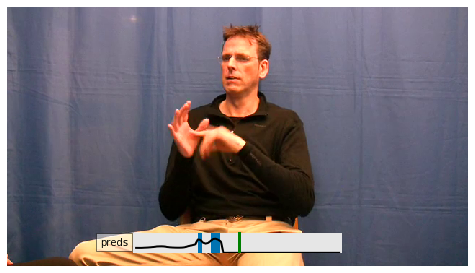

In [7]:
main_asformer(features, logits,**vars(dem_args))